<a href="https://colab.research.google.com/github/hyunseoki/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [ ]:
latent_dim = 100
lr = 0.0002

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim))
            layers.append(nn.LeakyReLU())
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), ## unpacking
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self. model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        flatten = img.view(img.size(0), -1)
        out = self.model(flatten)

        return out

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
generator = Generator(latent_dim=100)
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

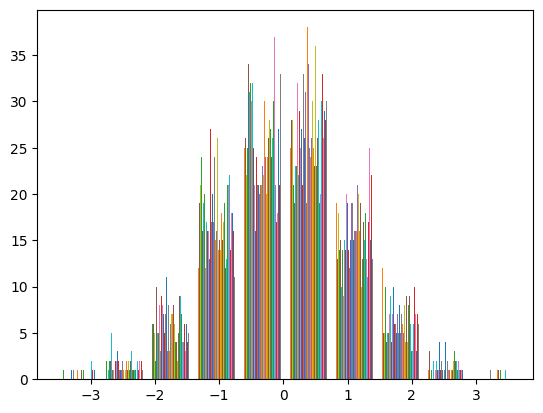

In [ ]:
z = torch.normal(mean=0, std=1, size=(128, latent_dim))
plt.hist(z)
plt.show()

In [ ]:
import time

n_epochs = 200
sample_interval = 2000
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        ''' Generator ''' 
        optimizer_G.zero_grad()        
        generated_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(generated_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        ''' Discriminator ''' 
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)
            
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.669869] [G loss: 2.214885] [Elapsed time: 17.60s]
[Epoch 1/200] [D loss: 0.371743] [G loss: 1.933373] [Elapsed time: 34.22s]
[Epoch 2/200] [D loss: 0.473400] [G loss: 1.681514] [Elapsed time: 52.52s]
[Epoch 3/200] [D loss: 0.452691] [G loss: 2.046515] [Elapsed time: 69.97s]
[Epoch 4/200] [D loss: 0.461675] [G loss: 0.725202] [Elapsed time: 86.36s]
[Epoch 5/200] [D loss: 1.028056] [G loss: 3.167903] [Elapsed time: 103.08s]
[Epoch 6/200] [D loss: 0.447604] [G loss: 1.505370] [Elapsed time: 120.83s]
[Epoch 7/200] [D loss: 0.457216] [G loss: 2.249043] [Elapsed time: 137.17s]
[Epoch 8/200] [D loss: 0.546006] [G loss: 0.593914] [Elapsed time: 153.65s]
[Epoch 9/200] [D loss: 0.538484] [G loss: 1.870672] [Elapsed time: 170.61s]
[Epoch 10/200] [D loss: 0.392694] [G loss: 1.280941] [Elapsed time: 187.89s]
[Epoch 11/200] [D loss: 0.378539] [G loss: 1.440861] [Elapsed time: 204.28s]
[Epoch 12/200] [D loss: 0.567765] [G loss: 0.701532] [Elapsed time: 220.66s]
[Epoch 13/200]

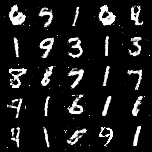

In [ ]:
from IPython.display import Image

Image('92000.png')